## Goal

1. Select pair of correlated parameters from air_quality dataset 
2. Train classic linear regresion
3. Train Bayesian lienar regresion
4. Visualize results in both cases

###  Imports

In [287]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
import seaborn as sns

In [288]:
pyro.set_rng_seed(1)
pyro.enable_validation(True)

### Data preparation

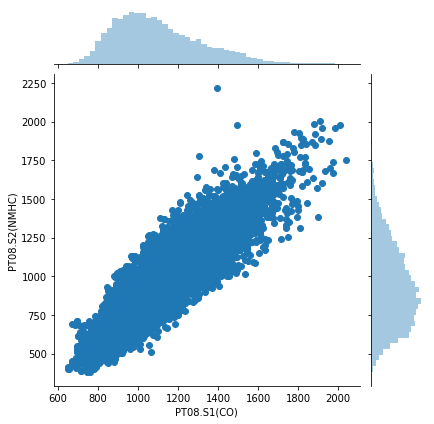

In [289]:
def load_and_preprocess_air_quality_dataset():
    data = pd.read_csv("air_quality.csv",sep=';')
    data['PT08.S1(CO)']=data['PT08.S1(CO)'].apply(lambda x: float(x))
    data['PT08.S2(NMHC)']=data['PT08.S2(NMHC)'].apply(lambda x: float(x))
    return data

all_data=load_and_preprocess_air_quality_dataset()
x=torch.tensor(all_data['PT08.S1(CO)'])
y=torch.tensor(all_data['PT08.S2(NMHC)'])

sns.jointplot(x='PT08.S1(CO)', y='PT08.S2(NMHC)', data=all_data)

x_vertical=x[:,None]
y_vertical=y[:,None]



### Linear regression 

  6%|▌         | 234/4000 [00:00<00:05, 745.00it/s]

[iteration 0100] loss: 153720656.0000
[iteration 0200] loss: 153546272.0000


 10%|▉         | 398/4000 [00:00<00:04, 777.36it/s]

[iteration 0300] loss: 153427024.0000
[iteration 0400] loss: 153283408.0000


 16%|█▌        | 628/4000 [00:00<00:04, 739.68it/s]

[iteration 0500] loss: 153117920.0000
[iteration 0600] loss: 152932192.0000


 21%|██        | 847/4000 [00:01<00:04, 727.19it/s]

[iteration 0700] loss: 152727408.0000
[iteration 0800] loss: 152504576.0000


 25%|██▌       | 1010/4000 [00:01<00:03, 766.47it/s]

[iteration 0900] loss: 152264448.0000
[iteration 1000] loss: 152007744.0000


 31%|███▏      | 1255/4000 [00:01<00:03, 789.08it/s]

[iteration 1100] loss: 151735104.0000
[iteration 1200] loss: 151447152.0000


 35%|███▌      | 1417/4000 [00:01<00:03, 763.69it/s]

[iteration 1300] loss: 151144496.0000
[iteration 1400] loss: 150827744.0000


 42%|████▏     | 1664/4000 [00:02<00:02, 800.37it/s]

[iteration 1500] loss: 150497488.0000
[iteration 1600] loss: 150154384.0000


 46%|████▌     | 1830/4000 [00:02<00:02, 779.38it/s]

[iteration 1700] loss: 149799104.0000
[iteration 1800] loss: 149432272.0000


 50%|█████     | 2006/4000 [00:02<00:02, 824.13it/s]

[iteration 1900] loss: 149054656.0000
[iteration 2000] loss: 148666960.0000


 55%|█████▍    | 2196/4000 [00:02<00:02, 852.30it/s]

[iteration 2100] loss: 148269920.0000
[iteration 2200] loss: 147864352.0000


 62%|██████▏   | 2478/4000 [00:03<00:01, 886.47it/s]

[iteration 2300] loss: 147451040.0000
[iteration 2400] loss: 147030816.0000


 66%|██████▋   | 2660/4000 [00:03<00:01, 838.86it/s]

[iteration 2500] loss: 146604480.0000
[iteration 2600] loss: 146172896.0000


 71%|███████   | 2831/4000 [00:03<00:01, 838.55it/s]

[iteration 2700] loss: 145736912.0000
[iteration 2800] loss: 145297360.0000


 75%|███████▌  | 3001/4000 [00:03<00:01, 775.00it/s]

[iteration 2900] loss: 144855104.0000
[iteration 3000] loss: 144410944.0000


 82%|████████▏ | 3260/4000 [00:04<00:00, 826.49it/s]

[iteration 3100] loss: 143965728.0000
[iteration 3200] loss: 143520240.0000


 86%|████████▌ | 3429/4000 [00:04<00:00, 786.96it/s]

[iteration 3300] loss: 143075264.0000
[iteration 3400] loss: 142631568.0000


 90%|█████████ | 3612/4000 [00:04<00:00, 845.99it/s]

[iteration 3500] loss: 142189856.0000
[iteration 3600] loss: 141750848.0000


 95%|█████████▍| 3791/4000 [00:04<00:00, 866.84it/s]

[iteration 3700] loss: 141315200.0000
[iteration 3800] loss: 140883552.0000


100%|██████████| 4000/4000 [00:04<00:00, 801.47it/s]


[iteration 3900] loss: 140456480.0000
[iteration 4000] loss: 140034560.0000
Wyuczone parametry:
noise 0.33245590329170227
linear.weight [[ 0.60981178]]
linear.bias [-90.59853363]


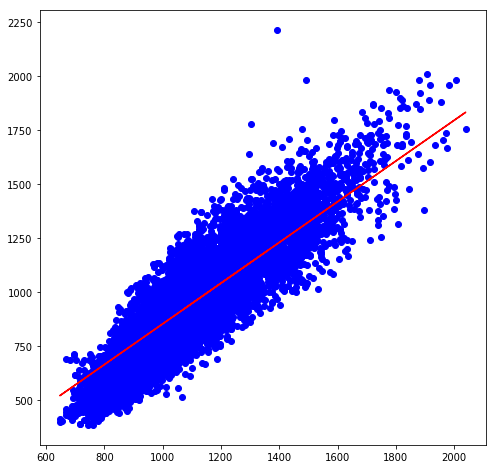

In [295]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1) # odpowiada za wagę w i bias b
        self.noise = nn.Parameter(torch.tensor(0.)) # data noise factor

    def forward(self, x):
        return self.linear(x) + (self.noise * x)
    
#uczenie polega na aktualizowaniu wartości parametrów na podstawie bledu mse 
#liczonego dla całego zbioru w każdej iteracji
def train_linear_regression(x, y):
    model=LinearRegressionModel()
    mse_function = torch.nn.MSELoss(reduction='sum')
    optim = torch.optim.Adam(model.parameters(), lr=0.05)
    num_iterations = 4000
    for j in tqdm(range(num_iterations)):
        y_pred = model(x)
        mse_loss = mse_function(y_pred, y)
        optim.zero_grad()
        mse_loss.backward()
        optim.step()
        if (j + 1) % 100 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, mse_loss.item()))
    print("Wyuczone parametry:")
    for name, param in model.named_parameters():
        print(name, param.data.numpy())
    return model

trained_model = train_linear_regression(x_vertical, y_vertical)

def plotLinearReggresionResults(model,x,y):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    plt.plot(x.squeeze().numpy(), y.squeeze().numpy(), "bo")
    y_learned=model.forward(x)
    plt.plot(x.squeeze().numpy(), y_learned.detach().squeeze().numpy(), 'r');

plotLinearReggresionResults(trained_model,x_vertical, y_vertical)


### Bayesian linear regression model

In [298]:
#model stochastyczny nadpisujący regresję liniową o rozkłady a priori parametrów
#model generuje obserwacje na podstawie wyuczonych średnich na bazie regresji ze znamymi
#wartościami a priori parametrów
def create_probabilistic_model():
    regression_model=LinearRegressionModel()
    def probabilistic_model(x_data, y_data):
        # weight and bias priors
        w_prior = pyro.distributions.Normal(torch.ones(1, 1)*3, torch.ones(1, 1)).to_event(1)
        b_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
        f_prior = pyro.distributions.Normal(0., 1000.)
        priors = {'linear.weight': w_prior, 'linear.bias': b_prior, 'noise': f_prior}
        scale = pyro.sample("sigma", pyro.distributions.Uniform(0., 18.))
        # lift module parameters to random variables sampled from the priors
        lifted_module = pyro.random_module("module", regression_model, priors)
        # sample a nn (which also samples w and b)
        lifted_reg_model = lifted_module()
        with pyro.plate("map", len(x_data)):
            # run the nn forward on data
            prediction_mean = lifted_reg_model(x_data).squeeze(-1)
            # condition on the observed data
            obs=pyro.sample("obs",
                        pyro.distributions.Normal(prediction_mean, scale),
                        obs=y_data)
            return prediction_mean
    return probabilistic_model


In [300]:
# w oparciu o dane i obserwacje wyuczam model - parametry a posteriori 
#guide odpowiadająca wartościom a posteriori przybliżana jest przez SVI 
#do a posteriori poprzez minimalizowanie błędu ELBO
def train():
    pyro.clear_param_store()
    num_iterations=1000
    model = create_probabilistic_model()
    guide = AutoDiagonalNormal(model)
    optim = pyro.optim.Adam({"lr": 0.01})
    svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=count)
    t=tqdm(range(num_iterations))
    for j in t:
        loss = svi.step(x_vertical, y_vertical.squeeze(-1))
        t.set_postfix(loss=loss)
    return (model, svi)

probabilistic_model, svi = train()

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

100%|██████████| 1000/1000 [00:08<00:00, 118.56it/s, loss=4.75e+6]


auto_loc tensor([1.0264, 0.4474, 0.4474, 0.4088], requires_grad=True)
auto_scale tensor([0.5762, 0.3069, 0.3087, 1.2687], grad_fn=<AddBackward0>)


In [302]:
def get_marginal(traces, sites):
    empirical_marginal=EmpiricalMarginal(traces, sites)
    return empirical_marginal._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        site_marginal=marginal[:, i]
        marginal_site = pd.DataFrame(site_marginal).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats





In [303]:
#opakowane po to by zyskać pedykcje
def wrapped_model(x_data, y_data):
    model_result=probabilistic_model(x_data, y_data)
    pyro.sample("prediction", pyro.distributions.Delta(model_result))


posterior = svi.run(x_vertical, y_vertical)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_vertical, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"] #wartości predykowane
y = post_summary["obs"] #obserwacje z modelu
predictions = pd.DataFrame({
    "rugged": x_vertical[:, 0],
    "x": x_vertical,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "mu_perc_25": mu["25%"],
    "mu_perc_75": mu["75%"],
    "y_perc_25": y["25%"],
    "y_perc_75": y["75%"],
    "true_y": y_vertical,
})


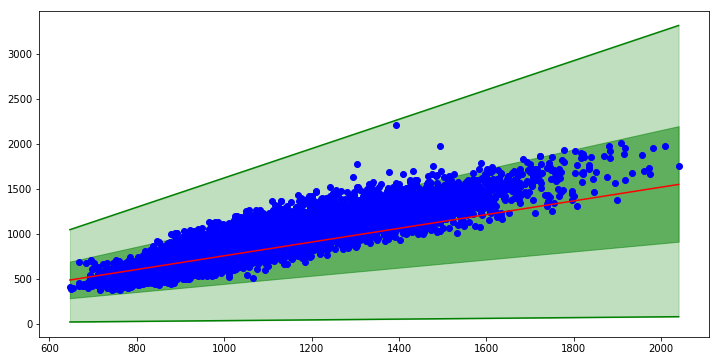

In [304]:
predictions = predictions.sort_values(by=["rugged"])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

x_values=x_vertical.squeeze().numpy()
x_2=np.sort(x_values)
plt.plot(x_values, y_vertical.squeeze().numpy(), "bo")
plt.plot(x_2, predictions['mu_mean'], 'r');
plt.plot(x_2, predictions['mu_perc_5'], 'g');
plt.plot(x_2, predictions['mu_perc_95'], 'g');
plt.fill_between(x_2,
                   predictions["mu_perc_25"],
                   predictions["mu_perc_75"],
                   color='g',
                   alpha=0.5);
plt.fill_between(x_2,
                   predictions["mu_perc_5"],
                   predictions["mu_perc_95"],
                   color='g',
                   alpha=0.25);

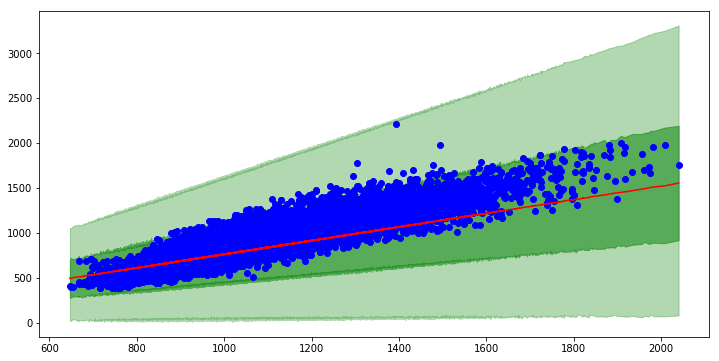

In [308]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_vertical.squeeze().numpy()
plt.plot(x_values, y_vertical.squeeze().numpy(), "bo")
plt.plot(x_2, predictions['y_mean'], 'r');
plt.fill_between(x_2,
                   predictions["y_perc_25"],
                   predictions["y_perc_75"],
                   color='g',
                   alpha=0.5);
plt.fill_between(x_2,
                   predictions["y_perc_5"],
                   predictions["y_perc_95"],
                   color='g',
                   alpha=0.3);

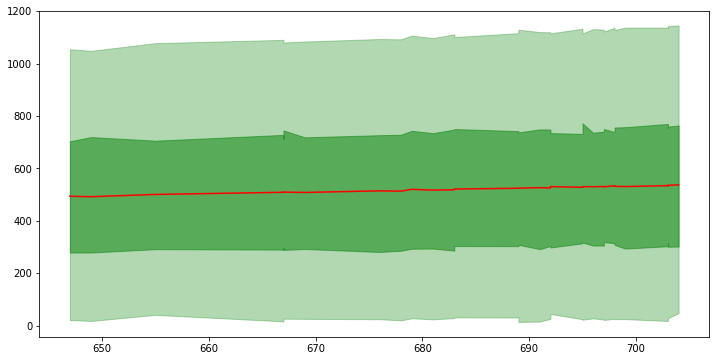

In [320]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_vertical.squeeze().numpy()
# plt.plot(x_values[0:50], y_vertical.squeeze().numpy()[0:50], "bo")
plt.plot(x_2[0:30], predictions['y_mean'][0:30], 'r');
plt.fill_between(x_2[0:30],
                   predictions["y_perc_25"][0:30],
                   predictions["y_perc_75"][0:30],
                   color='g',
                   alpha=0.5);
plt.fill_between(x_2[0:30],
                   predictions["y_perc_5"][0:30],
                   predictions["y_perc_95"][0:30],
                   color='g',
                   alpha=0.3);